This notebook is an analysis and prediction of the survival status of passengers on the titanic. The datasets are part of Kaggle and code was written by Brent Kuenzi

#### Variable definitions
- survival = Survival
- pclass = Ticket class
- sex = Sex	
- Age = Age in years	
- sibsp = # of siblings / spouses aboard the Titanic	
- parch = # of parents / children aboard the Titanic	
- ticket = Ticket number	
- fare = Passenger fare	
- cabin = Cabin number	
- embarked = Port of Embarkation

In [332]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

## Remove uninformative variables & convert strings

In [333]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
del train["Ticket"]; del train["Cabin"]
ID = train["PassengerId"]; del train["PassengerId"]
train["Sex"] = train["Sex"].replace("male",0);train["Sex"] = train["Sex"].replace("female",1)
train["Embarked"] = train["Embarked"].replace("S",0)
train["Embarked"] = train["Embarked"].replace("C",1)
train["Embarked"] = train["Embarked"].replace("Q",2)
surv = train["Survived"]; del train["Survived"]

## Deal with NAs
1) All the ages with no data make the median of the most likely group based on their name
    - "Master" is most likely young boy
    - "Miss" is most likely girl or young woman
    - "Mr" is most likely man
    - "Mrs" is most likely woman

2) All missing embarks just make them embark from most common place

3) All the missing prices assume median of their respective class

In [334]:
master=[];miss=[];mr=[];mrs=[]
for i in range(len(train["Age"])):
    if "Master" in train["Name"][i]:
        if not np.isnan(train["Age"][i]):
            master.append(train["Age"][i])
    if "Miss" in train["Name"][i]:
        if not np.isnan(train["Age"][i]):
            miss.append(train["Age"][i])
    if "Mr." in train["Name"][i]:
        if not np.isnan(train["Age"][i]):
            mr.append(train["Age"][i])
    if "Mrs." in train["Name"][i]:
        if not np.isnan(train["Age"][i]):
            mrs.append(train["Age"][i])

In [335]:
age = []
for i in range(len(train["Age"])):
    if np.isnan(train["Age"][i]):
        if "Master" in train["Name"][i]:
            age.append(np.median(master))
        elif "Miss" in train["Name"][i]:
            age.append(np.median(miss))
        elif "Ms." in train["Name"][i]:
            age.append(np.median(miss))
        elif "Mr." in train["Name"][i]:
            age.append(np.median(mr))
        elif "Mrs." in train["Name"][i]:
            age.append(np.median(mrs))
        else:
            age.append(train["Age"].median())
    else:
        age.append(train["Age"][i])

In [336]:
#train["Age"] = train["Age"].fillna(train["Age"].median())
#train["Age"] = train["Age"].fillna(train.groupby("Sex")["Age"].transform('median'))
train["Age"] = age
del train["Name"]

In [337]:
train["Embarked"] = train["Embarked"].fillna(np.max(train["Embarked"].value_counts()))

In [338]:
train["Fare"] = train["Fare"].fillna(train.groupby(["Pclass","Age"])["Fare"].transform('median'))

In [339]:
train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,22.0,1,0,7.2500,0.0
1,1,1,38.0,1,0,71.2833,1.0
2,3,1,26.0,0,0,7.9250,0.0
3,1,1,35.0,1,0,53.1000,0.0
4,3,0,35.0,0,0,8.0500,0.0


In [340]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, surv, test_size=0.1, random_state=42)

In [341]:
regr_rf = RandomForestRegressor(max_depth=7, random_state=2)
fit = regr_rf.fit(X_train, y_train)
predictions = fit.predict(X_test)

In [342]:
def probability_cutoff(array, probability):
    output = []
    for i in array:
        if i < probability:
            output.append(0)
        else:
            output.append(1)
    return output

## Test and train accuracy
Predictions are classified based on rounding up or down to 0 or 1


In [343]:
# Train and Test Accuracy
from sklearn.metrics import accuracy_score
for i in [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.7,0.75,0.8,0.85,0.9,0.95,1]:
    print str(i) + ": train=" + str(accuracy_score(y_train, probability_cutoff(fit.predict(X_train),i))) + ", test="+str(accuracy_score(y_test, probability_cutoff(predictions,i)))
predictions_cutoff = probability_cutoff(predictions,0.5)

0.05: train=0.455680399501, test=0.422222222222
0.1: train=0.664169787765, test=0.588888888889
0.15: train=0.791510611735, test=0.7
0.2: train=0.8177278402, test=0.733333333333
0.25: train=0.847690387016, test=0.766666666667
0.3: train=0.878901373283, test=0.811111111111
0.35: train=0.896379525593, test=0.822222222222
0.4: train=0.901373283396, test=0.844444444444
0.45: train=0.897627965044, test=0.855555555556
0.5: train=0.900124843945, test=0.844444444444
0.55: train=0.893882646692, test=0.844444444444
0.6: train=0.885143570537, test=0.833333333333
0.7: train=0.866416978777, test=0.822222222222
0.75: train=0.852684144819, test=0.811111111111
0.8: train=0.843945068664, test=0.8
0.85: train=0.827715355805, test=0.777777777778
0.9: train=0.807740324594, test=0.766666666667
0.95: train=0.786516853933, test=0.766666666667
1: train=0.755305867665, test=0.755555555556


# Train on full dataset and make predictions

In [344]:
fit = regr_rf.fit(train, surv)

In [345]:
del test["Ticket"]
del test["Cabin"]
ID2 = test["PassengerId"]; del test["PassengerId"]
test["Embarked"] = test["Embarked"].replace("S",0)
test["Embarked"] = test["Embarked"].replace("C",1)
test["Embarked"] = test["Embarked"].replace("Q",2)
test["Sex"] = test["Sex"].replace("male",0);test["Sex"] = test["Sex"].replace("female",1)
test["Embarked"] = test["Embarked"].fillna(np.max(test["Embarked"].value_counts()))
test["Fare"] = test["Fare"].fillna(test.groupby("Pclass")["Fare"].transform('median'))

In [346]:
master=[];miss=[];mr=[];mrs=[]
for i in range(len(test["Age"])):
    if "Master" in test["Name"][i]:
        if not np.isnan(test["Age"][i]):
            master.append(test["Age"][i])
    if "Miss" in test["Name"][i]:
        if not np.isnan(test["Age"][i]):
            miss.append(test["Age"][i])
    if "Mr." in test["Name"][i]:
        if not np.isnan(test["Age"][i]):
            mr.append(test["Age"][i])
    if "Mrs." in test["Name"][i]:
        if not np.isnan(test["Age"][i]):
            mrs.append(test["Age"][i])
age = []
for i in range(len(test["Age"])):
    if np.isnan(test["Age"][i]):
        if "Master" in test["Name"][i]:
            age.append(np.median(master))
        elif "Miss" in test["Name"][i]:
            age.append(np.median(miss))
        elif "Ms." in test["Name"][i]:
            age.append(np.median(miss))
        elif "Mr." in test["Name"][i]:
            age.append(np.median(mr))
        elif "Mrs." in test["Name"][i]:
            age.append(np.median(mrs))
        else:
            age.append(test["Age"].median())
    else:
        age.append(test["Age"][i])
test["Age"] = age
del test["Name"]

In [347]:
output = fit.predict(test)

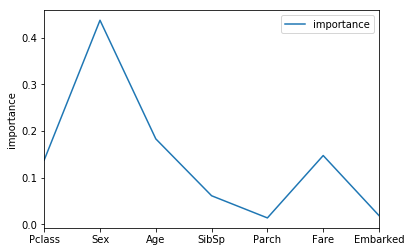

In [348]:
%matplotlib inline
features = pd.DataFrame({"variable" : train.columns, "importance":fit.feature_importances_})
features.plot(x="variable",y="importance")
plt.ylabel("importance"); plt.xlabel("")

In [349]:
output_class = []
for i in output:
    if i <= 0.5:
        output_class.append(0)
    else:
        output_class.append(1)
outputDF = pd.DataFrame({"PassengerId":ID2, "Survived":output_class})
outputDF.to_csv("titanic_predictions.csv",)